In [1]:
# !pip install kagglehub torch torchvision pillow matplotlib numpy scikit-learn lgbt tensorboard albumentations cv2 segmentation-models-pytorch
%load_ext tensorboard

In [2]:
import os
import datetime

from lgbt import lgbt
import kagglehub
import torch
import torch.nn as nn
# import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
import numpy as np
# from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.checkpoint import checkpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from segmentation_models_pytorch.utils.metrics import IoU
from segmentation_models_pytorch.losses import DiceLoss

/home/buklinfur/projects/4semester_ai/DL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

data_dir = path + "/tiff"

Path to dataset files: /home/buklinfur/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1


In [ ]:
def get_transforms():
    train_transform = A.Compose([
        # A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomCrop(512, 512),
        # A.ColorJitter(
        #     brightness=0.2, 
        #     contrast=0.2, 
        #     saturation=0.2, 
        #     hue=0.1, 
        #     p=0.3
        # ),
        A.RandomBrightnessContrast(p=0.3),
        A.ISONoise(p=0.5),
        A.GaussNoise(p=0.2),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet RGB stats
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})

    val_test_transform = A.Compose([
        # A.Resize(512, 512),
        A.RandomCrop(512, 512),
        # A.CenterCrop(512, 512),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})

    return train_transform, val_test_transform

In [5]:
class RoadsDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        mask = (mask > 0).float()
        mask = mask.unsqueeze(0)
        return image, mask

In [6]:
def prepare_datasets():
    train_image_dir = os.path.join(data_dir, "train")
    train_mask_dir = os.path.join(data_dir, "train_labels")
    val_image_dir = os.path.join(data_dir, "val")
    val_mask_dir = os.path.join(data_dir, "val_labels")
    test_image_dir = os.path.join(data_dir, "test")
    test_mask_dir = os.path.join(data_dir, "test_labels")

    train_images = sorted([os.path.join(train_image_dir, f) for f in os.listdir(train_image_dir)]) [:100]
    train_masks = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)]) [:100]
    val_images = sorted([os.path.join(val_image_dir, f) for f in os.listdir(val_image_dir)])
    val_masks = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])
    test_images = sorted([os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir)])
    test_masks = sorted([os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir)])

    for img, mask in zip(train_images, train_masks):
        assert os.path.basename(img) == os.path.basename(mask)+'f', \
            f"Train filename mismatch: {img} vs {mask}"
    
    for img, mask in zip(val_images, val_masks):
        assert os.path.basename(img) == os.path.basename(mask)+'f', \
            f"Val filename mismatch: {img} vs {mask}"
    
    for img, mask in zip(test_images, test_masks):
        assert os.path.basename(img) == os.path.basename(mask)+'f', \
            f"Test filename mismatch: {img} vs {mask}"
        
    train_transform, val_test_transform = get_transforms()

    train_dataset = RoadsDataset(train_images, train_masks, transform=train_transform)
    val_dataset = RoadsDataset(val_images, val_masks, transform=val_test_transform)
    test_dataset = RoadsDataset(test_images, test_masks, transform=val_test_transform)

    return train_dataset, val_dataset, test_dataset

In [7]:
def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image_tensor * std + mean

/tmp/ipykernel_122691/833198554.py:6: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),


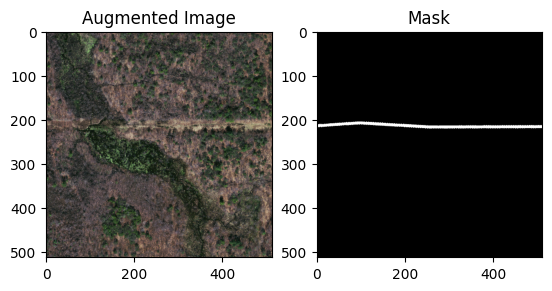

In [8]:
train_set, val_set, test_set = prepare_datasets()

image, mask = train_set[1]
plt.subplot(121)
plt.title("Augmented Image")
denorm_image = denormalize(image).permute(1, 2, 0)
plt.imshow(denorm_image)  # Undo normalization
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.squeeze(), cmap='gray')
plt.show()

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=64):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features)
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool1 = UNet._pool(features, features) 
        self.encoder2 = UNet._block(features, features * 2)
        # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = UNet._pool(features * 2, features * 2) 
        self.encoder3 = UNet._block(features * 2, features * 4)
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = UNet._pool(features * 4, features * 4)
        self.encoder4 = UNet._block(features * 4, features * 8)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = UNet._pool(features * 8, features * 8)

        self.bottleneck = UNet._block(features * 8, features * 16)

        self.upconv4 = UNet._upconv(features * 16, features * 8) # new upconv + bn + relu
        self.decoder4 = UNet._block(features * 16, features * 8)
        self.upconv3 = UNet._upconv(features * 8, features * 4) 
        self.decoder3 = UNet._block(features * 8, features * 4)
        self.upconv2 = UNet._upconv(features * 4, features * 2) 
        self.decoder2 = UNet._block(features * 4, features * 2)
        self.upconv1 = UNet._upconv(features * 2, features)
        self.decoder1 = UNet._block(features * 2, features)

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = checkpoint(self.encoder2, self.pool1(enc1), use_reentrant=False)
        enc3 = checkpoint(self.encoder3, self.pool2(enc2), use_reentrant=False)
        enc4 = checkpoint(self.encoder4, self.pool3(enc3), use_reentrant=False)

        bottleneck = checkpoint(self.bottleneck, self.pool4(enc4), use_reentrant=False)

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1) # skip connection
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1) 
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1) 
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1) 
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))
    
    @staticmethod
    def _pool(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels,
                kernel_size=3, 
                stride=2, 
                padding=1
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    @staticmethod
    def _upconv(in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,     
                output_padding=1
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, targets):
        # bce = nn.BCELoss()(inputs, targets)
        bce = nn.BCEWithLogitsLoss()(inputs, targets)
        
        # intersection = (inputs * targets).sum()
        # dice = (2. * intersection + 1e-6) / (inputs.sum() + targets.sum() + 1e-6)

        dice = DiceLoss('binary') (inputs, targets)
        
        # union = (inputs + targets).sum() - intersection
        # iou = (intersection + 1e-6) / (union + 1e-6) # added iou to target it directly
        
        # return 0.5*bce + (1 - dice) + (1 - iou) 
        return 0.4*bce + 0.6*dice

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-3
epochs = 200
batch_size = 6

lib_iou = IoU(threshold=0.5)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

fixed_idx = np.random.randint(len(val_set))
sample_image, sample_mask = val_set[fixed_idx]

model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,  
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)
# scheduler = torch.optim.lr_scheduler.CyclicLR(
#     optimizer,
#     base_lr=1e-3,          
#     max_lr=1e-2,     
#     step_size_up=700,  
#     mode='triangular2',    #'triangular', 'triangular2', 'exp_range'
#     cycle_momentum=False
# )

criterion = DiceBCELoss()


print(device)

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

cuda


In [12]:
def calculate_metrics(pred, target):
    pred = (pred > 0.5).float()
    eps = 1e-6
    
    intersection = (pred * target).sum()
    union = (pred + target).sum()
    
    iou = (intersection + eps) / (union + eps)
    dice = (2. * intersection + eps) / (pred.sum() + target.sum() + eps)
    
    return iou.item(), dice.item()

In [13]:
def visualize_sample(model, sample_image, sample_mask, epoch):
    model.eval()
    with torch.no_grad():
        pred_mask = model(sample_image.unsqueeze(0).to(device)).squeeze().cpu()
    
    image_np = denormalize(sample_image).permute(1, 2, 0).numpy()
    true_mask_np = sample_mask.squeeze().numpy()
    pred_mask_np = pred_mask.squeeze().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image_np)
    axes[0].set_title("Input Image")
    axes[0].axis('off')
    
    axes[1].imshow(true_mask_np, cmap='gray')
    axes[1].set_title("True Mask")
    axes[1].axis('off')
    
    axes[2].imshow(pred_mask_np > 0.5, cmap='gray')
    axes[2].set_title(f"Predicted Mask (Epoch {epoch})")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:
def train_model():
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = f"logs/roads_{current_time}"
    writer = SummaryWriter(log_dir)

    best_val_loss = float('inf')
    
    for epoch in range(epochs):

        model.train()
        train_loss = 0.0

        train_bar = lgbt(train_loader, desc = f'Train {epoch+1}/{epochs}', hero = 'unicorn')
        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            writer.add_scalar('Learning Rate/new_lr', optimizer.param_groups[0]['lr'], epoch*len(train_loader))
            
            running_loss = loss.item() * images.size(0)
            train_loss += running_loss

            # scheduler.step(running_loss)

        model.eval()
        val_loss = 0.0
        total_iou = 0.0
        total_dice = 0.0
        total_lib_iou = 0.0

        val_bar = lgbt(val_loader, desc = f'Val {epoch+1}/{epochs}', hero = 'kitten')
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                
                for i in range(outputs.shape[0]):
                    iou, dice = calculate_metrics(outputs[i], masks[i])
                    iou_lib = lib_iou(outputs, masks)
                    total_lib_iou += iou_lib
                    total_iou += iou
                    total_dice += dice
                
        
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_iou = total_iou / len(val_loader.dataset)
        val_dice = total_dice / len(val_loader.dataset)
        val_lib_iou = total_lib_iou / len(val_loader.dataset)

        scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val IoU: {val_iou:.4f} | Val Dice: {val_dice:.4f} | Val lib IoU: {val_lib_iou:.4f}")
        
        if ((epoch+1)%5 == 0):
            visualize_sample(model, sample_image, sample_mask, epoch+1)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Saved best model!")

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        
        writer.add_scalar('Metrics/val_IoU', val_iou, epoch)
        writer.add_scalar('Metrics/val_Dice', val_dice, epoch)
        writer.add_scalar('Metrics/val_Lib_IoU', val_lib_iou, epoch)

In [15]:
%tensorboard --logdir logs

In [1]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))
# train_model()

In [23]:
def test_model(model, test_loader):
    model.eval()
    total_iou = 0.0
    total_dice = 0.0
    total_lib_iou = 0.0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = (outputs > 0.5).float()
            
            running_iou, running_dice = calculate_metrics(preds, masks)
            running_lib_iou = lib_iou(preds, masks)
            
            total_iou += running_iou
            total_dice += running_dice
            total_lib_iou += running_lib_iou

    return total_iou/len(test_loader), total_dice/len(test_loader), total_lib_iou/len(test_loader)

Test results: IoU 0.35250868399937946	Dice 0.7050173679987589	Lib IoU 0.546129584312439


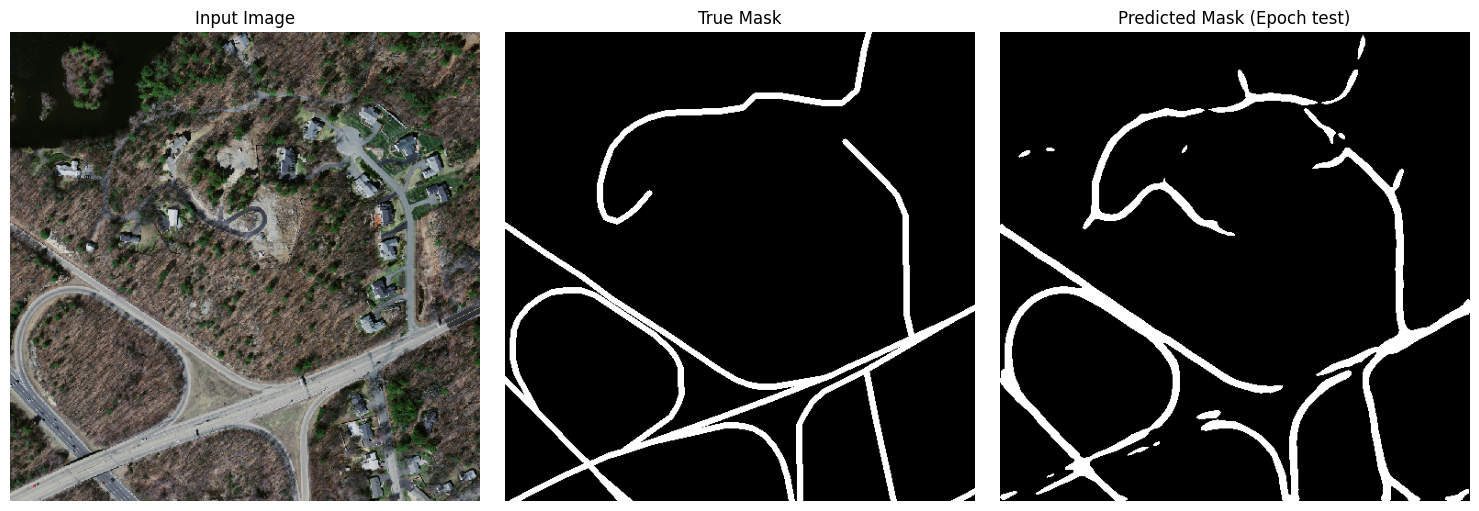

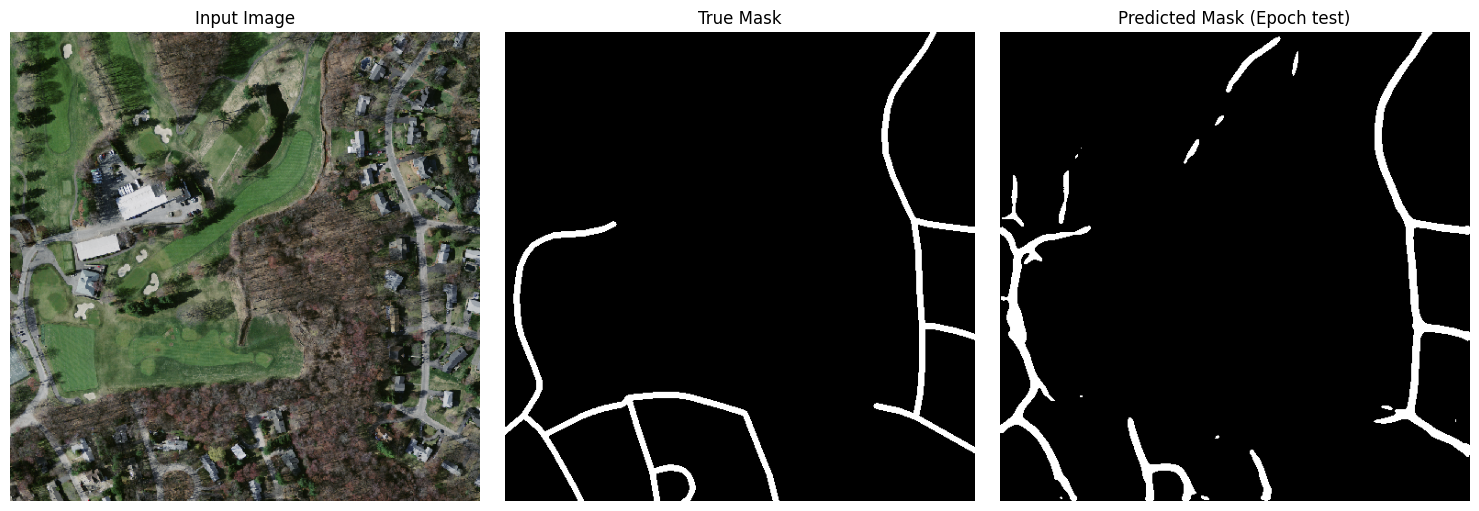

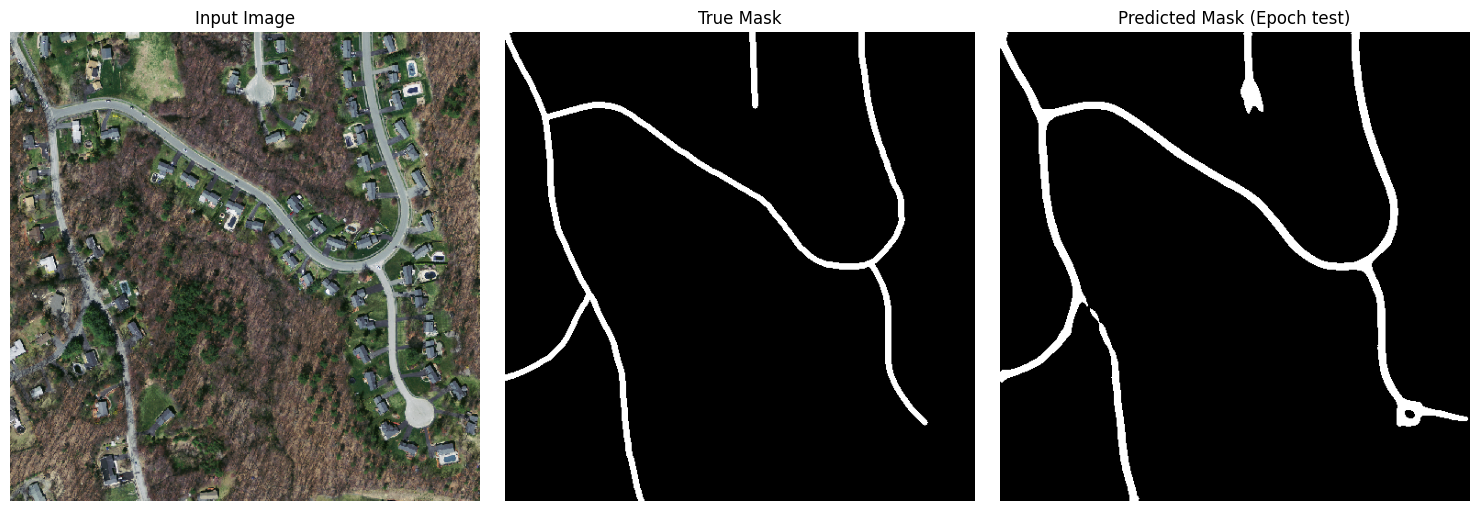

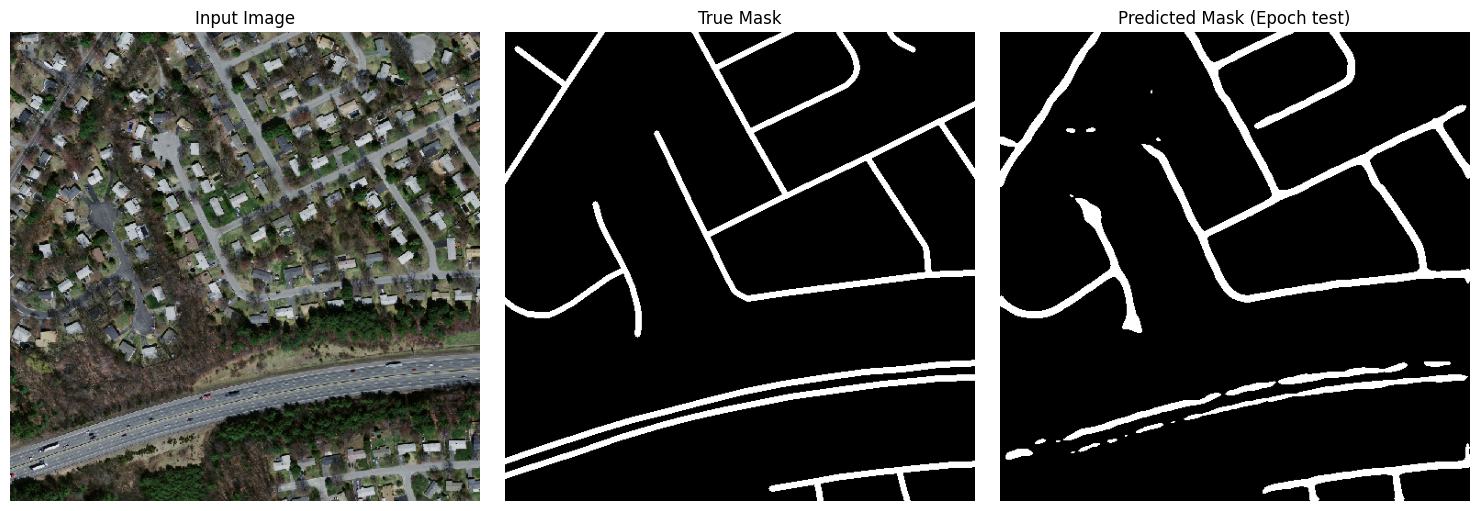

In [ ]:
model = UNet().to(device)
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

test_iou, test_dice, test_lib_iou = test_model(model, test_loader)
print (f'Test results: IoU {test_iou:.4f}\tDice {test_dice:.4f}\tLib IoU {test_lib_iou:.4f}')

for _ in range (4):
    fixed_idx = np.random.randint(len(test_set))
    sample_image, sample_mask = test_set[fixed_idx]

    visualize_sample(model, sample_image, sample_mask, "test")